## Fully-connected Neural Networks with Keras

As part of this tutorial, we are going to revist the MNIST image classification use case using classical fully-connected (also dense) artificial neural networks (FC-NN, Dense-NN). In the basic form of such a neural network, each of the neurons in the network is a single logistic regression. We employ multiple of these units in order to be able to model highly complex, non-linear separation boundaries between individual classes (see also the XOR-problem).

Thereby, the individual neurons are usually arranged in so-called layers that connected with each other in a directed acyclic structure. There are usually at least two layers, the input and output layer, where the data samples are passed in, and the prediction read out respectively. Additionally, there may be a number of hidden layers, additional logistic regression units, allowing to model higher-order functions. Each of the neurons within a layer is connected to every unit of the previous and subsequent layer, implementing a layer-wise full (hence the name) connectivity. Having more than one hidden unit is bluntly put deep-learning.

![FCNN](images/fc-nn.png)
<div align="center" style="color: #aaaaaa; font-size: 0.7em;">© Medium.com [1]</div>


### Setup

For a detailed explanation of the use modules, please refer to the respective sections in the [introductory notebook](0_MNIST_dataset.ipynb) and the one on [logistic regression](1_logistic_regression.ipynb).

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.


### Loading the Data

We will once again load the MNIST database from the HDF5 file. For details, please also see the [introductory notebook](MNIST dataset.ipynb).

In [125]:
def load_data(path='mnist.h5'):
    """
    Loads a dataset and its supervisor labels from the HDF5 file specified by the path.
    It is assumed that the HDF5 dataset containing the data is called 'data' and the labels are called 'labels'.

    Parameters
    ----------
    path : str, optional
        The absolute or relative path to the HDF5 file, defaults to mnist.h5.

    Returns
    -------
    data_and_labels : tuple(np.array[samples, width, height], np.array[samples])
        a tuple with two numpy array containing the data and labels
    """
    with h5py.File(path, 'r') as handle:
        return np.array(handle['/data']), np.array(handle['/labels'])
    
data, labels = load_data()
data.shape, labels.shape

((70000, 28, 28), (70000,))

### Preprocessing the Data

Just like in the logistic regression tutorial, we consider each of the individual pixels of an image as one of the features of our classical problem. This means, we will again flatten the image into a long vector of 28 x 28 = 784 elements. 

Additionally, we will from now on also only consider the multiclass classification problem, of identifying for all image the correct digit class from all of the available ten. Therefore, we need to think about how we encode our supervisor labels. The naïve approach would be to have a single output neuron and let it simply predict the number it thinks it depicted in the image. This approach, however, has two major downsides. First, the output neuron value range would be unbound, and a prediction of say *-1* or *11* could be reasonably expected. Second, in an output format like this some numbers would be illogically more similar to each other (due to their absolute difference) than they are in reality. The digit *7* for example would be very similar to *6* and *8* and not to *1*.

To counteract this effect, we are going to choose a different label encoding instead. For each samples, we will translate the label into a vector that is as long as the number of unique classes (here: 10). Each of the positions in the vector is uniquely associated with one of the individual classes and is set to 1 if the data sample is member of the respective class and 0 otherwise. Using this encoding, also called one-hot-encoding [2], each class has the same distance to every other class and we can additionally interpret the output again to be the probability of the data item belonging to each individual class.

\begin{align}
1 & \rightarrow [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] \\
7 & \rightarrow [0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 
\end{align}

One of the downsides of the proposed one-hot encoding method is a significantly increased memory footprint. In large-scale machine learning applications it might be necessary to use techniques like embedding or sparse matrix formats for the proper output encoding.

In [129]:
def preprocess_data(data, labels):
    """
    Flattens the each image in the data to be a one-dimensional feature vector and encodes the labels in one-hot encoding.

    Parameters
    ----------
    data : np.array[samples, width, height]
        the image dataset
    labels : np.array[samples]
        the corresponding labels

    Returns
    -------
    data_and_labels : tuple(np.array[samples, width * height], np.array[samples, classes])
        a tuple with two numpy array containing the flattened data and one-hot encoded labels
    """
    return data.reshape(data.shape[0], -1), to_categorical(labels)

preprocessed_data, preprocessed_labels = preprocess_data(data, labels)

### Training and Test Dataset Partitioning

In order to be able to judge whether our machine learning algorithm actually learns a pattern and does not simply memorize the training data, we need to verify whether it is able to correctly predict unseen or "new" data. One way of emulating this behaviour, is to artificially split the whole input dataset into disjoint training and test data (sometimes additionally validation data for model hyperparameter optimization) and use the former for adjusting the internal model parameters and the latter for testing the out-of-sample performance. 

In [130]:
def partition(data, labels, train_fraction=0.8):
    """
    Flattens the each image in the data to be a one-dimensional feature vector and encodes the labels in one-hot encoding.

    Parameters
    ----------
    data : np.array[samples, width * height]
        the image dataset
    labels : np.array[samples, classes]
        the corresponding labels
    train_fraction : float, optional
        the fraction between in [0.0, 1.0] of data items beeing assigned to the training dataset, defaults to 0.8

    Returns
    -------
    train_and_test_data : tuple(
        np.array[samples, width * height], np.array[samples, classes]
        np.array[samples, width * height], np.array[samples, classes]
    )
        a tuple with four numpy arrays containing the training data and labels as well as the test data and labels
    """
    ##############
    return the training and test data sets
##############

train_data, train_labels, test_data, test_labels = partition(preprocessed_data, preprocessed_labels)
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((56000, 784), (56000, 10), (14000, 784), (14000, 10))

### Building a Fully-connected Neural Network

Using the previously introduced (see [logistic regression notebook](Logistic Regression.ipynb)) Keras API for implementing a logistic regression, we may also implement fully-connected neural networks by increasing the number of neurons in one layer and adding more layers. Using the "softmax" activation function, we can realize a multi-class classifier with a joint output probability of 1. 

In [128]:
def build_model(data, classes):
    """
    Constructs a fully-connected neural network model for the given data and number of classes

    Parameters
    ----------
    data : np.array[samples, width * height]
        the image dataset
    classes : int
        the number of unique classes in the dataset

    Returns
    -------
    model : keras.Model
        the fully-connected neural network
    """
    model = Sequential()
    
    ##############
    add all the layers
    ##############
    
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model(preprocessed_data, classes=preprocessed_labels.shape[1])

### Setup for Model Training Progress Monitoring

Keras allows basic training monitoring through the output on the standard output and some pre-implemented callback functions. We would like to have a more fine-grained tracking for the training history in order to be able closely observe the progress for each batch. To do so, we extend a default Keras Callback class with our custom implementation that track the history for training and test phase.

In [131]:
class TrainingHistory(Callback):
    """
    Class for tracking the training progress/history of the neural network. Implements the keras.Callback interface.
    """
    def on_train_begin(self, logs):
        self.loss = []
        self.acc = []
        self.validation_loss = []
        self.validation_acc = []
        
    def on_batch_end(self, _, logs):
        """
        Callback invoked after each training batch.
        Should track the training loss and accuracy in the respective members.

        Parameters
        ----------
        _ : int
            unused, int corresponding to the batch number
        logs : dict{str -> float}
            a dictionary mapping from the observed quantity to the actual valu
        """
        if 'loss' in logs:
            self.loss.append(logs['loss'])
        if 'acc' in logs:
            self.acc.append(logs['acc'])
            
    def on_epoch_end(self, _, logs):
        if 'val_loss' in logs:
            self.validation_loss.append(logs['val_loss'])
        if 'val_acc' in logs:
            self.validation_acc.append(logs['val_acc'])

### Training a Model

Training a fully-connected neural network works analogous to [logistic regression](Logistic Regression.ipynb) using the Keras API.

In [29]:
def train_model(model, train_data, train_labels, test_data, test_labels, epochs=50, batch_size=64):
    """
    Trains a fully-connected neural network given training and test data/labels.

    Parameters
    ----------
    model : keras.Model
        the fully-connected neural network
    train_data : np.array[samples, width * height]
        the training data
    train_labels : np.array[samples, classes]
        the one-hot encoded training labels
    test_data : np.array[samples, width * height]
        the test data
    test_labels : np.array[samples, classes]
        the one-hot encoded test labels
    epoch: positive int, optional
        the number of epochs for which the neural network is trained, defaults to 50
    batch_size: positive int, optional
        the size of the training batches, defaults to 64

    Returns
    -------
    history : TrainingHistory
        the tracked training and test history
    """
    history = TrainingHistory()
    ##############
    fit the model  # also pass validation_data=(test_data, test_labels,), shuffle=True, callbacks=[history]
    ##############
    return history
    
history = train_model(model, train_data, train_labels, test_data, test_labels)

Train on 56000 samples, validate on 14000 samples
Epoch 1/50
56000/56000 [==============================] - 10s 178us/step - loss: 1.7132 - acc: 0.6377 - val_loss: 1.2045 - val_acc: 0.7900
Epoch 2/50
56000/56000 [==============================] - 10s 175us/step - loss: 0.9849 - acc: 0.8152 - val_loss: 0.7647 - val_acc: 0.8534
Epoch 3/50
56000/56000 [==============================] - 9s 164us/step - loss: 0.7105 - acc: 0.8459 - val_loss: 0.5921 - val_acc: 0.8724
Epoch 4/50
56000/56000 [==============================] - 10s 170us/step - loss: 0.5882 - acc: 0.8615 - val_loss: 0.5048 - val_acc: 0.8814
Epoch 5/50
56000/56000 [==============================] - 10s 172us/step - loss: 0.5203 - acc: 0.8705 - val_loss: 0.4519 - val_acc: 0.8905
Epoch 6/50
56000/56000 [==============================] - 10s 178us/step - loss: 0.4770 - acc: 0.8768 - val_loss: 0.4179 - val_acc: 0.8951
Epoch 7/50
56000/56000 [==============================] - 10s 175us/step - loss: 0.4471 - acc: 0.8814 - val_loss: 0.3

### Visualization of the Training Progress

Using the previously created and filled TrainingHistory instance, we are able to plot the loss and accuracy of the training batches and test epochs.

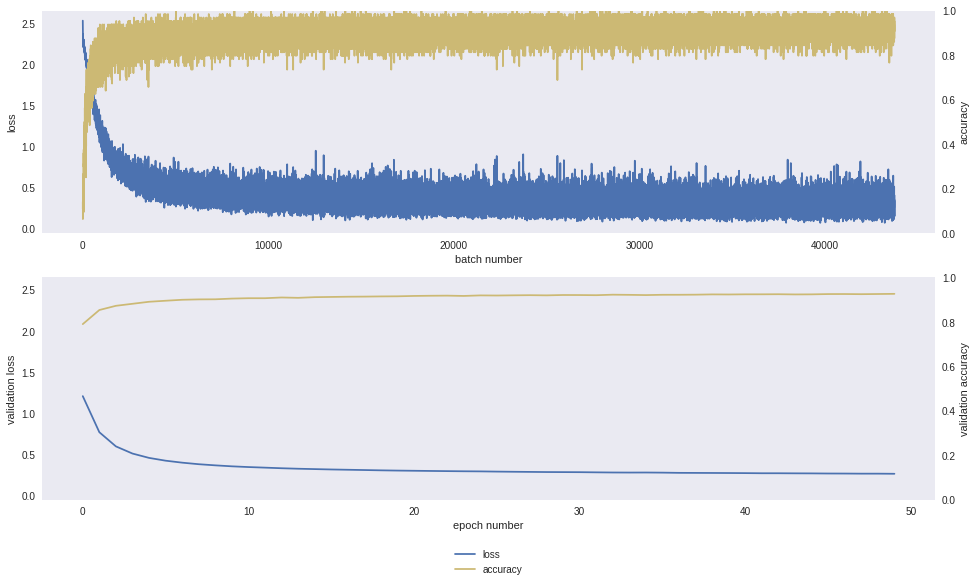

In [139]:
def plot_history(history):
    """
    Plots the training (batch-wise) and test (epoch-wise) loss and accuracy.

    Parameters
    ----------
    history : TrainingHistory
        an instance of TrainingHistory monitoring callback
    """
    figure, (batch_axis, epoch_axis) = plt.subplots(2, 1, figsize=(16, 9), sharey=True)
    
    # plot the training loss and accuracy
    batch_axis.set_xlabel('batch number')
    training_batches = np.arange(len(history.loss))
    
    batch_axis.grid(False)
    batch_axis.plot(training_batches, history.loss, color='C0', label='loss')
    batch_axis.set_ylabel('loss')
    
    batch_acc_axis = batch_axis.twinx()
    batch_acc_axis.grid(False)
    batch_acc_axis.set_ylabel('accuracy')
    batch_acc_axis.set_ylim(bottom=0.0)
    batch_acc_axis.plot(training_batches, history.acc, color='C4', label='accuracy')
    
    # plot the training loss and accuracy
    epoch_axis.set_xlabel('epoch number')
    validation_epochs = np.arange(len(history.validation_loss))
    
    epoch_axis.grid(False)
    epoch_axis.plot(validation_epochs, history.validation_loss, color='C0')
    epoch_axis.set_ylabel('validation loss')
    
    epoch_acc_axis = epoch_axis.twinx()
    epoch_acc_axis.grid(False)
    epoch_acc_axis.set_ylabel('validation accuracy')
    epoch_acc_axis.set_ylim(bottom=0.0)
    epoch_acc_axis.plot(validation_epochs, history.validation_acc, color='C4')
    
    # display a legend
    figure.legend(loc=8)
    plt.show()

plot_history(history)

### Prediction of "New Data"


Using a previously trained model, we are able to predict the classes of new "unseen" data. A prediction produces for each of the input data samples a 10-item long vector where each vector position contains the probability of the data item belonging to the respective class.

In [32]:
def predict(model, test_data, batch_size=64):
    """
    Predicts for a given fully-connected neural network and a number of data samples the resulting classes.

    Parameters
    ----------
    model : keras.Model
        the fully-connected neural network
    test data : np.array[samples, width * height]
        the data to be predicted
    batch_size: positive int, optional
        the size of the training batches, defaults to 64

    Returns
    -------
    prediction : np.array[samples, classes]
        a class prediction for each class
    """
    ##############
    return all the predictions for the given data and parameters
##############

test_prediction = predict(model, test_data)
test_prediction.shape

((56000, 10), (14000, 10))

### Let See Some Examples...

... in order to see how well our model works. Using the predictions on the test data, we can use a bar plot to visualize all the class membership probabilities of the respective images. Green bars indicate the original true class, while red bars indicate mispredictions.

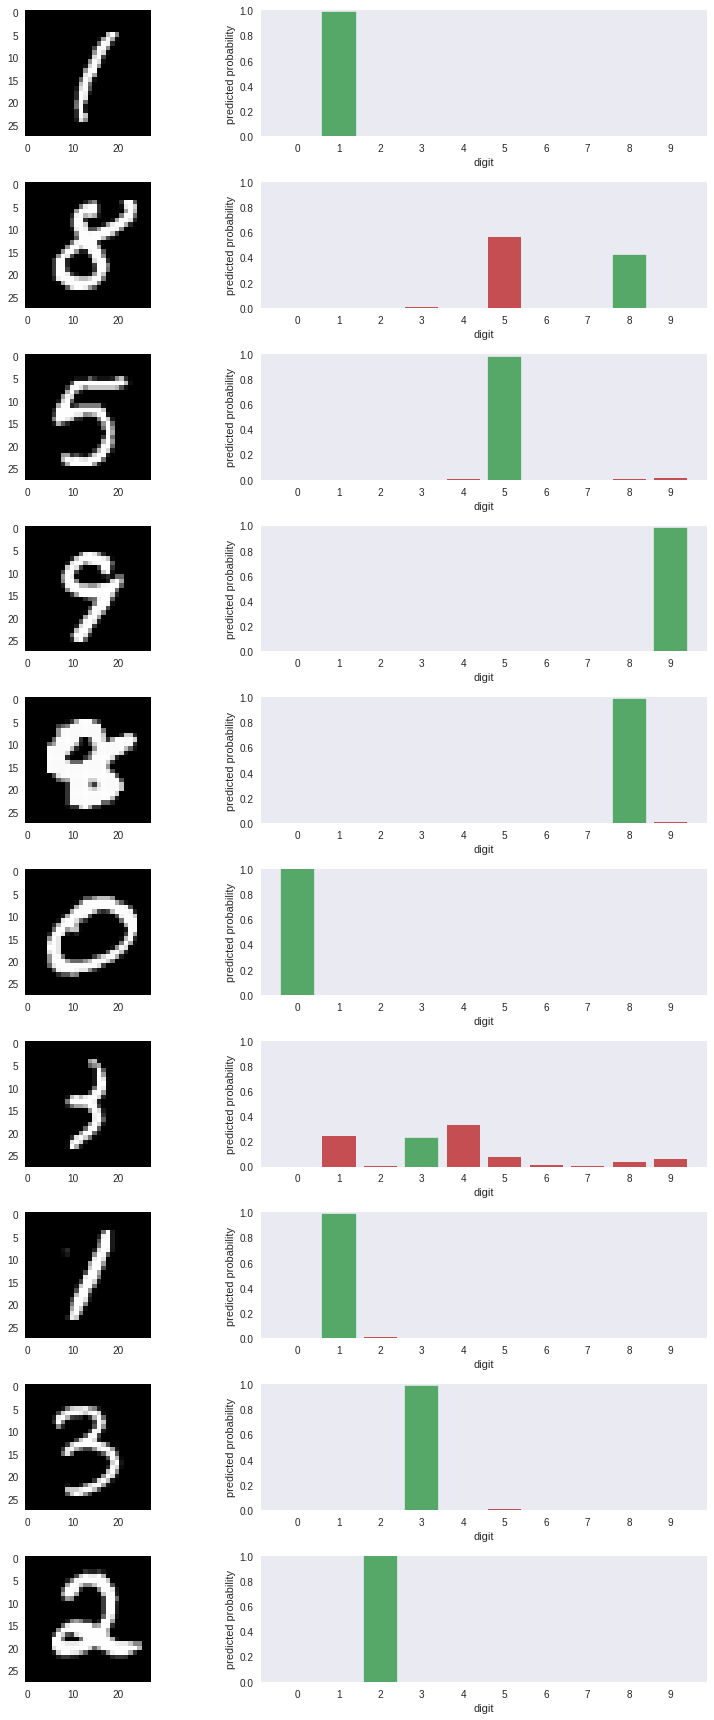

In [55]:
def visualize_prediction(data, labels, prediction, how_many=10):
    """
    Visualizes for a given number of test images the class membership prediction made by our neural network.

    Parameters
    ----------
    data : np.array[samples, width * height]
        the test image
    labels : np.array[samples, classes]
        the actual one-hot encoded labels for each image
    prediction: np.array[samples, classes]
        the one-hot encoded predictions for each image
    how_many : positive int, optional
        indicates how many samples shall be displayed starting from the first, defaults to 10
    """
    figure, axes = plt.subplots(how_many, 2, figsize=(12, 24))
    digits = np.arange(labels.shape[1])
    
    for i in range(how_many):
        left, right = axes[i]
        
        left.imshow(data[i].reshape(28, 28), cmap='gist_gray')
        left.grid(False)
        
        bars = right.bar(digits, prediction[i], color='C2')
        ##############
        color the correct bar in green ('C1')
        ##############
        right.grid(False)
        
        right.set_xlabel('digit')
        right.set_xticks(digits)
        
        right.set_ylim(0.0, 1.0)
        right.set_ylabel('predicted probability')
        
    plt.tight_layout()
    plt.show()
    
visualize_prediction(test_data, test_labels, test_prediction)

### Where Did Things Go Wrong - The Confusion Matrix

A confusion matrix is a visual way of comparing the overall predictions with the ground-truth labels. For this, a we create a class x class-sized matrix where we each position is equivalent to the relative frequency of the prediction given a particular class label. An optimal confusion matrix would result in a matrix with each of the diagonal elements equal to 1. In practice we will obviously not achieve this. Instead, with this mode of presentation we are able to judge what kind of class labels the prediction algorithm commonly confuses with other class and, potentially, take c

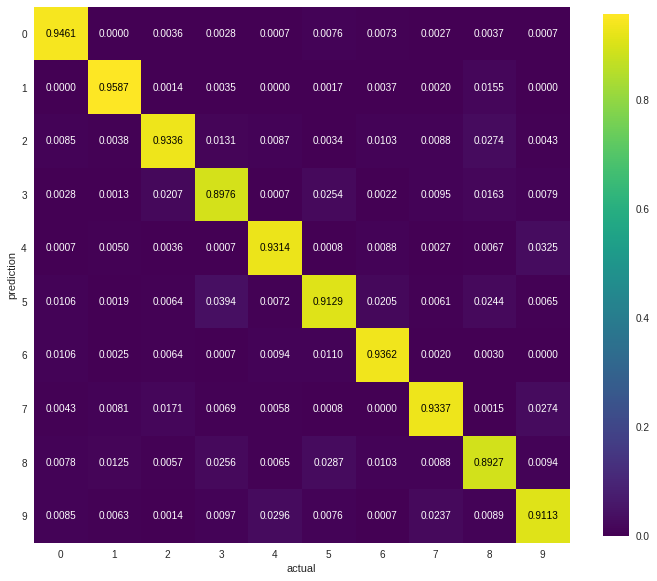

In [133]:
def show_confusion_matrix(labels, prediction):
    """
    Computes and visualizes the confusion matrix for the test data.

    Parameters
    ----------
    labels : np.array[samples, classes]
        the actual labels of the data items
    prediction: np.array[samples, classes]
        the corresponding predictions of the neural network
    """
    classes = labels.shape[1]
    buckets = np.arange(classes)
    confusion = np.histogram2d(np.argmax(labels, axis=1), np.argmax(prediction, axis=1), bins=classes)[0]
    confusion /= confusion.sum(axis=0)
    
    figure, axis = plt.subplots(1, figsize=(12, 12))
    axis.grid(False)
    image = axis.imshow(confusion, cmap='viridis')
    axis.set_xlabel('actual')
    axis.set_xticks(buckets)
    axis.set_ylabel('prediction')
    axis.set_yticks(buckets)
    figure.colorbar(image, shrink=0.8)
    
    for y in range(classes):
        for x in range(classes):
            value = confusion[y, x]
            color = 'white' if value <= 0.5 else 'black'
            plt.annotate('{:.4f}'.format(float(value)), xy=(x, y), color=color, ha='center', va='center')
            
    plt.show()

show_confusion_matrix(test_labels, test_prediction)

### References

[1] **Fully-connected Neural Network**, *Venelin Valkov*, (2017), [external link](https://medium.com/@curiousily/tensorflow-for-hackers-part-iv-neural-network-from-scratch-1a4f504dfa8).

[2] **One-hot**, *Wikipedia*, (2018), [external link](https://en.wikipedia.org/wiki/One-hot).